Update the clustering Process

* Before
    * Using Bert embeddings to do the clustering

* Now
    * Use TF-IDF vectors to perform clustering
    * Check text cleaning
    * Also Check the cluster pairs that were created and make sure the cluster pairs make sense

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)

import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, HTML
import torch
from tqdm import tqdm
import pickle
import h5py
import random

In [3]:
random.seed(42)

In [4]:
from Scripts.utils.general_utils import timer

from Scripts.utils.config import RANDOM_SEED

from Scripts.utils.preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from Scripts.utils.data_utils import load_data

from Scripts.utils.plotters_baseline import plot_size_dist

from Scripts.utils.bert_utils import load_model, load_tokenizer, batch_text_gen

from attm_utils import load_pickle

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
path = "../articles.csv"

main_df = load_data(path)

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4406 mins



In [6]:
path = "../sampled_articles_from_relevant_data.csv"

rel_df = load_data(path)

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'all_text'],
      dtype='object')
Df original shape : (100000, 6)
Df shape after dropping nan text : (100000, 6)
Df shape after dropping duplicate articles based on title : (99403, 6)
Df shape after dropping 0 stance articles : (99403, 6)

Finished running 'load_data' in 0.0699 mins



In [7]:
path = "../sampled_articles_from_relevant_data_extreme.csv"

rel_extreme_df = load_data(path)

Index(['title', 'text', 'source', 'source_partisan_score', 'binary_ps',
       'processed_text'],
      dtype='object')
Df original shape : (37306, 6)
Df shape after dropping nan text : (37306, 6)
Df shape after dropping duplicate articles based on title : (37298, 6)
Df shape after dropping 0 stance articles : (37298, 6)

Finished running 'load_data' in 0.0225 mins



In [8]:
main_df.head()

article_id  \
0     7065530   
1     7065529   
2     7065473   
3     7065467   
4     7065440   

                                                                                                                                                                                                                                   url  \
0                                                                                                                        https://www.vox.com/first-person/2018/11/29/18116789/trump-bolsonaro-right-wing-populism-voting-child-rearing   
1                                                                                                                       https://www.vox.com/platform/amp/culture/2016/12/27/14094400/carrie-fisher-dead-obituary-request-strangled-bra   
2  https://www.washingtonpost.com/local/obituaries/robert-trump-younger-brother-of-president-trump-who-filed-lawsuit-against-niece-dies-at-71/2020/08/15/6ec0f102-de62-11ea-8051-d5f887d73381_story.html#click=https://t.co/qpQtEWf7I2   
3                                                                               https://www.washingtonpost.com/science/insect-apocalypse-not-happening-yet-in-north-america/2020/08/14/cde0b190-dcb4-11ea-8051-d5f887d73381_story.html   
4                                               https://www.washingtonpost.com/world/europe/as-protesters-in-belarus-call-for-his-ouster-lukashenko-turns-to-putin-for-help/2020/08/16/0a7f60fe-df1e-11ea-b4f1-25b762cdbbf4_story.html   

                                                                                      title  \
0                How you think about raising children says a lot about your political views   
1     Carrie Fisher dead at 60, strangled by own bra (is the obituary Carrie Fisher wanted)   
2                              Robert Trump, younger brother of President Trump, dies at 71   
3  Perspective | No signs of large-scale insect apocalypse in North America yet, study says   
4          As protesters in Belarus call for his ouster, Lukashenko turns to Putin for help   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [9]:
rel_df.head(2)

title  \
0          Top general warns that 'divisiveness leads to defeat' as Pentagon concerns over politicization grow   
1  How the US government created a fake university to snare immigrant students | US immigration | The Guardian   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [10]:
rel_df["binary_ps"].value_counts().tolist()

[57905, 41498]

In [11]:
rel_df["Num_Tokens"] = rel_df["all_text"].apply(lambda x: len(x.split(" ")))

In [12]:
rel_df["Num_Tokens"].mean()

225.7159743669708

In [13]:
rel_df["Num_Tokens"].max()

1936

In [14]:
rel_df["Num_Tokens"].min()

35

<AxesSubplot:ylabel='Frequency'>

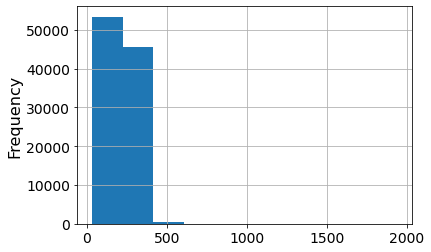

In [15]:
rel_df["Num_Tokens"].plot(kind="hist")

In [16]:
rel_df["processed_title"] = preprocess_texts(text_lists=rel_df["title"])

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces
Running : remove_non_alpha_numeric

Finished running 'preprocess_texts' in 0.0862 mins



In [17]:
rel_df["all_text"] = rel_df["processed_title"] + " " +rel_df["processed_text"]

In [18]:
rel_df["Num_Tokens_HL"] = rel_df["processed_title"].apply(lambda x: len(x.split(" ")))

In [19]:
rel_df["Num_Tokens_HL"].mean()

10.978491594821081

In [20]:
rel_df["Num_Tokens_HL"].max()

33

In [21]:
rel_df["Num_Tokens_HL"].min()

1

<AxesSubplot:ylabel='Frequency'>

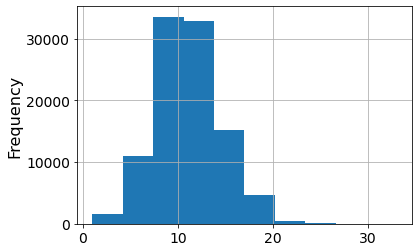

In [22]:
rel_df["Num_Tokens_HL"].plot(kind="hist")

In [23]:
rel_df.head(2)

title  \
0          Top general warns that 'divisiveness leads to defeat' as Pentagon concerns over politicization grow   
1  How the US government created a fake university to snare immigrant students | US immigration | The Guardian   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Keep Max Length of 350 Tokens when Using Bert Tokenizer

## Vectorization and Clustering

In [24]:
vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=rel_df,min_df=50,max_df=0.75,seed=RANDOM_SEED,max_features=20000,combine_text=False)

vocab_size : 15026

Finished running 'tfidf_vectorization' in 0.1702 mins




Running KMEANS Clustering with k=50

Finished running 'run_clustering' in 0.1419 mins


Finished running 'get_cluster_sizes' in 0.0002 mins



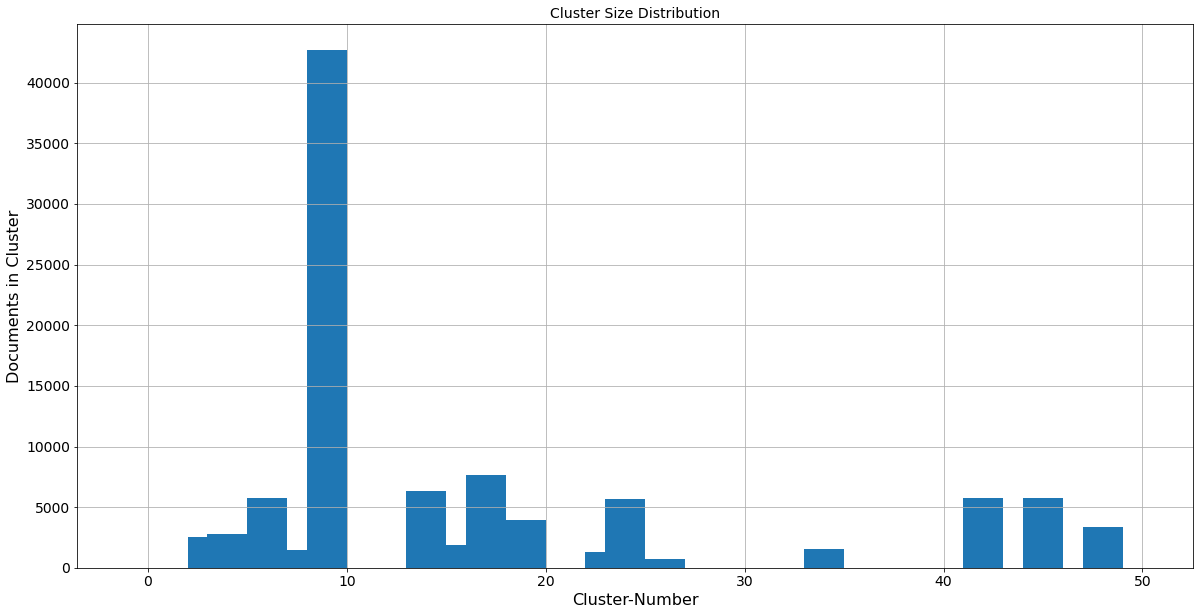

In [60]:
clusters,cluster_clf = run_clustering(vectors=vectors,seed=RANDOM_SEED,num_clusters=50,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

In [61]:
cluster_sizes.keys()

dict_keys([9, 45, 48, 19, 42, 3, 8, 26, 23, 17, 6, 14, 15, 34, 4, 24, 33, 46, 41, 5, 16, 40, 38, 47, 22, 1, 21, 25, 20, 31, 30, 13, 10, 39, 2, 27, 32, 43, 37, 29, 18, 36, 49, 35, 0, 44, 11, 12, 7, 28])

In [81]:
cluster_sizes[26]

721

* 95 - Immigration/ Border Wall
* 62 - Supreme court related issues
* 45 - Trump related + Trump Impeachment
* 72 - Taliban Related
* 54 - Trump Impeachment
* 99 - Welfare + stimulus checks
* 3 - Racism
* 85 - Trump Impeachment - Ukraine Related
* 70 - US Elections
* 30 - US Military

In [ ]:
48 - Immigration (3344)
19 - Law/ Crime/ Supreme Court (3924)
42 - Trump Impeachment (5793)
3 - Welfare/Stimulus (2556)
8 - Racism (1509)
26 - Technology / Big Tech (721)

In [69]:
doc_2_cluster_map = cluster2doc(num_texts=rel_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0003 mins



In [80]:
with open("doc_2_cluster_k_50.pkl","wb") as wb:
    pickle.dump(doc_2_cluster_map,wb)

In [82]:
c1_df = rel_df.iloc[doc_2_cluster_map[26]]

c1_df.head(5)

title  \
14   Adriana Cohen: Twitter not only politically biased, it's crossed over into election meddling, too   
136                                                      New 5G coalition features Facebook, Microsoft   
227                                                                 Friday's Campaign Round-Up, 8.7.20   
453               Opinion | Elizabeth Warren's plan for big tech makes her the Teddy Roosevelt of 2020   
486                                                    Obama 2012 and Google: Your Privacy, Diminished   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [30]:
len(doc_2_cluster_map[171])

671

In [31]:
def filter_clusters_size(cluster_sizes,min_size=300,max_size=3000):
    """
    """
    filtered_clusters = []
    for cluster in cluster_sizes.keys():
        if cluster_sizes[cluster] >= min_size and cluster_sizes[cluster] <= max_size:
            filtered_clusters.append(cluster)
    return filtered_clusters

def filter_by_partisan_dist(clusters,cluster_2_doc_map,df,partisan_dist_diff=0.20):
    """
    """
    filtered_clusters = []
    for c in clusters:
        print(c)
        c_docs_indices = cluster_2_doc_map[c]
        total_size = len(c_docs_indices)
        c_df = df["binary_ps"].iloc[c_docs_indices]
        ps_dist = c_df.value_counts().tolist()
        pos_dist = ps_dist[-1]/total_size
        neg_dist = ps_dist[0]/total_size
        dist_diff = np.abs(pos_dist - neg_dist)
        
        print("Dist_diff : %s" %str(dist_diff))
        
        if dist_diff <= partisan_dist_diff:
            filtered_clusters.append(c)
    
    return filtered_clusters

In [32]:
fil_clusters = filter_clusters_size(cluster_sizes,min_size=300,max_size=3000)

In [33]:
len(fil_clusters)

86

In [34]:
fil_ps_clusters = filter_by_partisan_dist(clusters=fil_clusters,
                                          cluster_2_doc_map=doc_2_cluster_map,
                                          df=rel_df,
                                          partisan_dist_diff=0.30)

84
Dist_diff : 0.19999999999999996
88
Dist_diff : 0.31363203050524313
129
Dist_diff : 0.3175074183976261
78
Dist_diff : 0.23887375113533155
126
Dist_diff : 0.1553648068669528
123
Dist_diff : 0.21028037383177572
35
Dist_diff : 0.15706806282722519
51
Dist_diff : 0.38028169014084506
113
Dist_diff : 0.2122370936902485
149
Dist_diff : 0.2173913043478261
270
Dist_diff : 0.3466666666666667
60
Dist_diff : 0.07647058823529407
252
Dist_diff : 0.459915611814346
56
Dist_diff : 0.49248120300751874
220
Dist_diff : 0.10852017937219727
75
Dist_diff : 0.06821705426356589
227
Dist_diff : 0.23642439431913115
243
Dist_diff : 0.4369369369369369
379
Dist_diff : 0.18077803203661325
47
Dist_diff : 0.12896622313203682
23
Dist_diff : 0.031192660550458662
58
Dist_diff : 0.04766146993318482
206
Dist_diff : 0.41333333333333333
49
Dist_diff : 0.12313432835820892
306
Dist_diff : 0.11323896752706081
70
Dist_diff : 0.2907348242811501
288
Dist_diff : 0.3333333333333333
5
Dist_diff : 0.012318029115341522
66
Dist_diff : 

In [35]:
print(len(fil_ps_clusters))

58


In [36]:
def create_cluster_pairs(clusters):
    cluster_pairs = []
    for pair in itertools.combinations(clusters,2):
        
        cluster_pairs.append(pair)
    
    return cluster_pairs

In [37]:
cluster_pairs = create_cluster_pairs(fil_ps_clusters)

In [38]:
print(len(cluster_pairs))

1653


In [39]:
def select_top_n_similar_cps(cps,cluster_clf,n=10):
    """
    """
    dist_matrix = cosine_similarity(cluster_clf.cluster_centers_)
    sorted_cps = sorted(cps,key=lambda x: dist_matrix[x[0],x[1]],reverse=True)[:n]
    return sorted_cps

In [40]:
top_10_sim_cps = select_top_n_similar_cps(cps=cluster_pairs,
                                          cluster_clf=cluster_clf,
                                          n=20)

In [41]:
top_10_sim_cps

[(58, 59),
 (123, 59),
 (66, 8),
 (47, 49),
 (58, 66),
 (349, 63),
 (81, 349),
 (306, 281),
 (23, 156),
 (66, 59),
 (123, 58),
 (49, 306),
 (58, 8),
 (23, 306),
 (173, 314),
 (126, 301),
 (220, 98),
 (123, 66),
 (81, 63),
 (23, 49)]

In [42]:
def analyze_cps(cps,df,cluster_2_doc_map):
    """
    """
    for cp in cps:
        print("\n******* %s ***********\n"%str(cp))
        c1_df = df.iloc[cluster_2_doc_map[cp[0]]]
        c2_df = df.iloc[cluster_2_doc_map[cp[1]]]
        
        display(c1_df[["title","text"]].head(5))
        print("\n")
        display(c2_df[["title","text"]].head(5))

In [43]:
analyze_cps(cps=top_10_sim_cps,df=rel_df,cluster_2_doc_map=doc_2_cluster_map)


******* (58, 59) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (123, 59) ***********



,title,text
7,Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup',"Rep. Liz Cheney (R-WY) on Monday said an intelligence official’s complaint that President Trump sought help from Ukraine in the 2020 elections “is starting to seem like a political setup.” Cheney tweeted a clip of House Speaker Nancy Pelosi (D-CA) appearing to admit she knew what was in the transcript of a July 25 Trump phone call with Ukrainian leader Volodymyr Zelensky even before the White House released the transcript of the call last Wednesday. Pelosi, in an interview that aired Sunday on CBS News 60 Minutes, said Trump called her and they discussed the phone call before the transcript was released. According to the New York Times, Trump and Pelosi’s phone call took place on Tuesday. The White House released the transcript on Wednesday. But Pelosi said during the interview about her call with Trump, “He told me it was perfect. There was nothing in the call. But I know what was in the call. I mean, we — it was in the public domain.” When Trump and Pelosi had spoken Tuesday, the call was not yet “in the public domain.” Fred Fleitz, a former CIA analyst and chief of staff to former National Security Adviser John Bolton, has questioned whether the intelligence official who lodged a whistleblower complaint against Trump had help writing the complaint from Democrat lawmakers or their staff members. He wrote in a New York Post op-ed on Thursday: I am very familiar with transcripts of presidential phone calls since I edited and processed dozens of them when I worked for the NSC. I also know a lot about intelligence whistleblowers from my time with the CIA. My suspicions grew this morning when I saw the declassified whistleblowing complaint. It appears to be written by a law professor and includes legal references and detailed footnotes. It also has an unusual legalistic reference on how this complaint should be classified. From my experience, such an extremely polished whistleblowing complaint is unheard of. This document looks as if this leaker had outside help, possibly from congressional members or staff. Moreover, it looks like more than a coincidence that this complaint surfaced and was directed to the House Intelligence Committee just after Adam Schiff (D-Calif.), an outspoken opponent of President Trump, expressed numerous complaints in August 2019 accusing President Trump of abusing aid to Ukraine to hurt Joe Biden. This includes an August 28 tweet that closely resembled the whistleblowing complaint. House Republicans need to ask the whistleblower under oath whether he spoke to the press or Congress about his complaint."
52,"Trump Snaps At Biden, Pelosi Over Coronavirus Criticism: ‘These People Are Sick’","President Donald Trump criticized House Speaker Nancy Pelosi and former Vice President Joe Biden Friday during a White House Memorial Day ceremony. The president called Pelosi and Biden “sick” over their criticism of his coronavirus response, pointing to his decision to ban travel from China in late January. (RELATED: ‘Hell Yes’: Over 200 Democrats Stand By ‘NO BAN Act’ Amid Coronavirus Pandemic) “I put a ban on China in January, and I took a lot of heat,” Trump said. “Joe Biden said, ‘oh, he’s xenophobic.’ Oh that’s right, yeah. But a month later he said I was right. As you know, Dr. Fauci, a good guy said ‘you don’t need to do that,’ and then later on when he saw that I did it, and when we kept thousands, tens of thousands of people out, he said, ‘Donald Trump saved thousands of lives, tens of thousands of lives.'” The president also went after Pelosi over her late February appearance in San Francisco’s Chinatown, where the speaker encouraged people to come out and patron businesses in the area. (RELATED: FLASHBACK: Jan.21: Fauci Says Coronavirus ‘Not A Major Threat’ To U.S.) “Nancy Pelosi, a month later, was in Chinatown in San Francisco. She’s dancing in the streets of Chinatown trying to say, ‘It’s ok to come to the United States, it’s 

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (66, 8) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (47, 49) ***********



title  \
44                    The truth about Sanders' Cold War comments is too complicated for cable news   
96                                       Bernie Sanders: ‘This is not the time for a protest vote’   
167                    Former RNC official sees 'ghosts' of Trump's 2016 race in Sanders' campaign   
243                                                           The Nordic Democratic-Socialist Myth   
244  ‘Disappointed’: Elizabeth Warren blasts Bernie Sanders after volunteers’ canvass script leaks   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (58, 66) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (349, 63) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (81, 349) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (306, 281) ***********



,title,text
55,Joe Biden attacks Donald Trump for 'shameful' claim he is 'against God',"Donald Trump has claimed Joe Biden is “against God” in an attack on the presumptive Democratic presidential candidate’s faith. In provocative remarks during a trip to Ohio, a key election battleground, the US president said Biden was “following the radical left agenda”. Trump added: “Take away your guns, destroy your second amendment. No religion, no anything, hurt the Bible, hurt God. “He’s against God, he’s against guns, he’s against energy, our kind of energy.” Biden, who is leading in the polls, has frequently spoken about how his Catholic faith helped him cope with the deaths of his first wife and daughter in a 1972 car accident. In a statement, he said Trump’s comments were “shameful”. He added: “Like so many people, my faith has been the bedrock foundation of my life: it’s provided me comfort in moments of loss and tragedy, it’s kept me grounded and humbled in times of triumph and joy. “And in this moment of darkness for our country – of pain, of division, and of sickness for so many Americans – my faith has been a guiding light for me and a constant reminder of the fundamental dignity and humanity that God has bestowed upon all of us. “For President Trump to attack my faith is shameful. It’s beneath the office he holds and it’s beneath the dignity the American people so rightly expect and deserve from their leaders.” Biden’s stance on abortion has antagonised many of his fellow Catholics. In 1973, he said the Roe v Wade supreme court decision went “too far”, but now believes Roe v Wade is “the law of the land, a woman has a right to choose”. Biden is dealing with a controversy of his own, after suggesting the African American community was homogenous – a comment Trump described as “very insulting”. Biden said: “What you all know but most people don’t know, unlike the African American community with notable exceptions, the Latino community is an incredibly diverse community with incredibly different attitudes about different things.” He later tweeted: “Earlier today, I made some comments about diversity in the African American and Latino communities that I want to clarify. In no way did I mean to suggest the African American community is a monolith – not by identity, not on issues, not at all. “My commitment to you is this: I will always listen, I will never stop fighting for the African American community and I will never stop fighting for a more equitable future.”"
141,Opinion | A Biden Presidency Could Be Better Than Progressives Think,"Biden wouldn’t need to pivot so dramatically to be a transformative progressive president. There are plenty of bleak moments in his record, including his treatment of Anita Hill and his Iraq war vote, but it’s not quite as reactionary as leftists sometimes imagine. Among other things, he’s long been better-than-average on unions; as Jared Bernstein, Biden’s former chief economist, told me, “One of the main things that differentiates Biden from a traditional mainstream Democrat is his understanding of the importance of worker power.” Still, it’s clear that he’s moving leftward. Biden recently came out for tuition-free college for students whose families earn less than $125,000. He endorsed Elizabeth Warren’s bankruptcy plan, something that would have been unimaginable in 2005, when Warren, then a Harvard law professor, charged onto the public stage to fight a regressive bankruptcy bill that Biden supported. After long supporting the Hyde Amendment, which bans federal funding for most abortions, Biden gave in to pro-choice pressure to come out against it. His climate plan already went beyond any of Barack Obama’s initiatives, and he’s pledged to make it even more robust. Biden’s health care proposal falls far short of single-payer, but it is, as Paul Waldman wrote in The Washington Post, “surprisingly liberal.” It will be in Biden’s political interests to try to make good on these commitments. “I’ve 

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (23, 156) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (66, 59) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (123, 58) ***********



,title,text
7,Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup',"Rep. Liz Cheney (R-WY) on Monday said an intelligence official’s complaint that President Trump sought help from Ukraine in the 2020 elections “is starting to seem like a political setup.” Cheney tweeted a clip of House Speaker Nancy Pelosi (D-CA) appearing to admit she knew what was in the transcript of a July 25 Trump phone call with Ukrainian leader Volodymyr Zelensky even before the White House released the transcript of the call last Wednesday. Pelosi, in an interview that aired Sunday on CBS News 60 Minutes, said Trump called her and they discussed the phone call before the transcript was released. According to the New York Times, Trump and Pelosi’s phone call took place on Tuesday. The White House released the transcript on Wednesday. But Pelosi said during the interview about her call with Trump, “He told me it was perfect. There was nothing in the call. But I know what was in the call. I mean, we — it was in the public domain.” When Trump and Pelosi had spoken Tuesday, the call was not yet “in the public domain.” Fred Fleitz, a former CIA analyst and chief of staff to former National Security Adviser John Bolton, has questioned whether the intelligence official who lodged a whistleblower complaint against Trump had help writing the complaint from Democrat lawmakers or their staff members. He wrote in a New York Post op-ed on Thursday: I am very familiar with transcripts of presidential phone calls since I edited and processed dozens of them when I worked for the NSC. I also know a lot about intelligence whistleblowers from my time with the CIA. My suspicions grew this morning when I saw the declassified whistleblowing complaint. It appears to be written by a law professor and includes legal references and detailed footnotes. It also has an unusual legalistic reference on how this complaint should be classified. From my experience, such an extremely polished whistleblowing complaint is unheard of. This document looks as if this leaker had outside help, possibly from congressional members or staff. Moreover, it looks like more than a coincidence that this complaint surfaced and was directed to the House Intelligence Committee just after Adam Schiff (D-Calif.), an outspoken opponent of President Trump, expressed numerous complaints in August 2019 accusing President Trump of abusing aid to Ukraine to hurt Joe Biden. This includes an August 28 tweet that closely resembled the whistleblowing complaint. House Republicans need to ask the whistleblower under oath whether he spoke to the press or Congress about his complaint."
52,"Trump Snaps At Biden, Pelosi Over Coronavirus Criticism: ‘These People Are Sick’","President Donald Trump criticized House Speaker Nancy Pelosi and former Vice President Joe Biden Friday during a White House Memorial Day ceremony. The president called Pelosi and Biden “sick” over their criticism of his coronavirus response, pointing to his decision to ban travel from China in late January. (RELATED: ‘Hell Yes’: Over 200 Democrats Stand By ‘NO BAN Act’ Amid Coronavirus Pandemic) “I put a ban on China in January, and I took a lot of heat,” Trump said. “Joe Biden said, ‘oh, he’s xenophobic.’ Oh that’s right, yeah. But a month later he said I was right. As you know, Dr. Fauci, a good guy said ‘you don’t need to do that,’ and then later on when he saw that I did it, and when we kept thousands, tens of thousands of people out, he said, ‘Donald Trump saved thousands of lives, tens of thousands of lives.'” The president also went after Pelosi over her late February appearance in San Francisco’s Chinatown, where the speaker encouraged people to come out and patron businesses in the area. (RELATED: FLASHBACK: Jan.21: Fauci Says Coronavirus ‘Not A Major Threat’ To U.S.) “Nancy Pelosi, a month later, was in Chinatown in San Francisco. She’s dancing in the streets of Chinatown trying to say, ‘It’s ok to come to the United States, it’s 

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (49, 306) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

,title,text
55,Joe Biden attacks Donald Trump for 'shameful' claim he is 'against God',"Donald Trump has claimed Joe Biden is “against God” in an attack on the presumptive Democratic presidential candidate’s faith. In provocative remarks during a trip to Ohio, a key election battleground, the US president said Biden was “following the radical left agenda”. Trump added: “Take away your guns, destroy your second amendment. No religion, no anything, hurt the Bible, hurt God. “He’s against God, he’s against guns, he’s against energy, our kind of energy.” Biden, who is leading in the polls, has frequently spoken about how his Catholic faith helped him cope with the deaths of his first wife and daughter in a 1972 car accident. In a statement, he said Trump’s comments were “shameful”. He added: “Like so many people, my faith has been the bedrock foundation of my life: it’s provided me comfort in moments of loss and tragedy, it’s kept me grounded and humbled in times of triumph and joy. “And in this moment of darkness for our country – of pain, of division, and of sickness for so many Americans – my faith has been a guiding light for me and a constant reminder of the fundamental dignity and humanity that God has bestowed upon all of us. “For President Trump to attack my faith is shameful. It’s beneath the office he holds and it’s beneath the dignity the American people so rightly expect and deserve from their leaders.” Biden’s stance on abortion has antagonised many of his fellow Catholics. In 1973, he said the Roe v Wade supreme court decision went “too far”, but now believes Roe v Wade is “the law of the land, a woman has a right to choose”. Biden is dealing with a controversy of his own, after suggesting the African American community was homogenous – a comment Trump described as “very insulting”. Biden said: “What you all know but most people don’t know, unlike the African American community with notable exceptions, the Latino community is an incredibly diverse community with incredibly different attitudes about different things.” He later tweeted: “Earlier today, I made some comments about diversity in the African American and Latino communities that I want to clarify. In no way did I mean to suggest the African American community is a monolith – not by identity, not on issues, not at all. “My commitment to you is this: I will always listen, I will never stop fighting for the African American community and I will never stop fighting for a more equitable future.”"
141,Opinion | A Biden Presidency Could Be Better Than Progressives Think,"Biden wouldn’t need to pivot so dramatically to be a transformative progressive president. There are plenty of bleak moments in his record, including his treatment of Anita Hill and his Iraq war vote, but it’s not quite as reactionary as leftists sometimes imagine. Among other things, he’s long been better-than-average on unions; as Jared Bernstein, Biden’s former chief economist, told me, “One of the main things that differentiates Biden from a traditional mainstream Democrat is his understanding of the importance of worker power.” Still, it’s clear that he’s moving leftward. Biden recently came out for tuition-free college for students whose families earn less than $125,000. He endorsed Elizabeth Warren’s bankruptcy plan, something that would have been unimaginable in 2005, when Warren, then a Harvard law professor, charged onto the public stage to fight a regressive bankruptcy bill that Biden supported. After long supporting the Hyde Amendment, which bans federal funding for most abortions, Biden gave in to pro-choice pressure to come out against it. His climate plan already went beyond any of Barack Obama’s initiatives, and he’s pledged to make it even more robust. Biden’s health care proposal falls far short of single-payer, but it is, as Paul Waldman wrote in The Washington Post, “surprisingly liberal.” It will be in Biden’s political interests to try to make good on these commitments. “I’ve 


******* (58, 8) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (23, 306) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

,title,text
55,Joe Biden attacks Donald Trump for 'shameful' claim he is 'against God',"Donald Trump has claimed Joe Biden is “against God” in an attack on the presumptive Democratic presidential candidate’s faith. In provocative remarks during a trip to Ohio, a key election battleground, the US president said Biden was “following the radical left agenda”. Trump added: “Take away your guns, destroy your second amendment. No religion, no anything, hurt the Bible, hurt God. “He’s against God, he’s against guns, he’s against energy, our kind of energy.” Biden, who is leading in the polls, has frequently spoken about how his Catholic faith helped him cope with the deaths of his first wife and daughter in a 1972 car accident. In a statement, he said Trump’s comments were “shameful”. He added: “Like so many people, my faith has been the bedrock foundation of my life: it’s provided me comfort in moments of loss and tragedy, it’s kept me grounded and humbled in times of triumph and joy. “And in this moment of darkness for our country – of pain, of division, and of sickness for so many Americans – my faith has been a guiding light for me and a constant reminder of the fundamental dignity and humanity that God has bestowed upon all of us. “For President Trump to attack my faith is shameful. It’s beneath the office he holds and it’s beneath the dignity the American people so rightly expect and deserve from their leaders.” Biden’s stance on abortion has antagonised many of his fellow Catholics. In 1973, he said the Roe v Wade supreme court decision went “too far”, but now believes Roe v Wade is “the law of the land, a woman has a right to choose”. Biden is dealing with a controversy of his own, after suggesting the African American community was homogenous – a comment Trump described as “very insulting”. Biden said: “What you all know but most people don’t know, unlike the African American community with notable exceptions, the Latino community is an incredibly diverse community with incredibly different attitudes about different things.” He later tweeted: “Earlier today, I made some comments about diversity in the African American and Latino communities that I want to clarify. In no way did I mean to suggest the African American community is a monolith – not by identity, not on issues, not at all. “My commitment to you is this: I will always listen, I will never stop fighting for the African American community and I will never stop fighting for a more equitable future.”"
141,Opinion | A Biden Presidency Could Be Better Than Progressives Think,"Biden wouldn’t need to pivot so dramatically to be a transformative progressive president. There are plenty of bleak moments in his record, including his treatment of Anita Hill and his Iraq war vote, but it’s not quite as reactionary as leftists sometimes imagine. Among other things, he’s long been better-than-average on unions; as Jared Bernstein, Biden’s former chief economist, told me, “One of the main things that differentiates Biden from a traditional mainstream Democrat is his understanding of the importance of worker power.” Still, it’s clear that he’s moving leftward. Biden recently came out for tuition-free college for students whose families earn less than $125,000. He endorsed Elizabeth Warren’s bankruptcy plan, something that would have been unimaginable in 2005, when Warren, then a Harvard law professor, charged onto the public stage to fight a regressive bankruptcy bill that Biden supported. After long supporting the Hyde Amendment, which bans federal funding for most abortions, Biden gave in to pro-choice pressure to come out against it. His climate plan already went beyond any of Barack Obama’s initiatives, and he’s pledged to make it even more robust. Biden’s health care proposal falls far short of single-payer, but it is, as Paul Waldman wrote in The Washington Post, “surprisingly liberal.” It will be in Biden’s political interests to try to make good on these commitments. “I’ve 


******* (173, 314) ***********



title  \
98                            Coronavirus on the border: California hospitals overwhelmed by patients from Mexico   
154                                          House Republicans demand details on Dems' mysterious trips to Mexico   
198               Trump wanted to shoot migrants and build a wall guarded by alligators and flesh-piercing spikes   
272  'Propaganda': Immigration Activist Group Raices Slams Netflix Series 'Border Security: America's Front Line'   
330                                                                A brief guide to the State of the Union guests   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

title  \
203                             Trump Is Trampling Dozens of Laws to Build His Border Wall. Here’s How.   
366                           Judge Allows Trump Admin to Survey Historic Church’s Land for Border Wall   
1294  Opinion | Trump’s border wall wouldn’t stop most illegal immigration or drugs. So what is it for?   
1992                        Defense Department Approves Funding For 20 Miles of U.S./Mexico Border Wall   
2084                            These Wall Street Companies Are Ready to Cash In on Trump’s Border Wall   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


******* (126, 301) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (220, 98) ***********



title  \
27                              If You're Trying To Ban Guns, The Least You Can Do Is Learn The Basics   
42  Analysis | Marco Rubio’s claim that no recent mass shootings would have been prevented by gun laws   
49                               Republicans Blocked A Gun Control Bill During Another School Shooting   
86                                                New Zealand Gun Buyback Was An ‘Unmitigated Failure’   
94                                           Fighting gun trafficking gets ensnared in political fight   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (123, 66) ***********



,title,text
7,Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup',"Rep. Liz Cheney (R-WY) on Monday said an intelligence official’s complaint that President Trump sought help from Ukraine in the 2020 elections “is starting to seem like a political setup.” Cheney tweeted a clip of House Speaker Nancy Pelosi (D-CA) appearing to admit she knew what was in the transcript of a July 25 Trump phone call with Ukrainian leader Volodymyr Zelensky even before the White House released the transcript of the call last Wednesday. Pelosi, in an interview that aired Sunday on CBS News 60 Minutes, said Trump called her and they discussed the phone call before the transcript was released. According to the New York Times, Trump and Pelosi’s phone call took place on Tuesday. The White House released the transcript on Wednesday. But Pelosi said during the interview about her call with Trump, “He told me it was perfect. There was nothing in the call. But I know what was in the call. I mean, we — it was in the public domain.” When Trump and Pelosi had spoken Tuesday, the call was not yet “in the public domain.” Fred Fleitz, a former CIA analyst and chief of staff to former National Security Adviser John Bolton, has questioned whether the intelligence official who lodged a whistleblower complaint against Trump had help writing the complaint from Democrat lawmakers or their staff members. He wrote in a New York Post op-ed on Thursday: I am very familiar with transcripts of presidential phone calls since I edited and processed dozens of them when I worked for the NSC. I also know a lot about intelligence whistleblowers from my time with the CIA. My suspicions grew this morning when I saw the declassified whistleblowing complaint. It appears to be written by a law professor and includes legal references and detailed footnotes. It also has an unusual legalistic reference on how this complaint should be classified. From my experience, such an extremely polished whistleblowing complaint is unheard of. This document looks as if this leaker had outside help, possibly from congressional members or staff. Moreover, it looks like more than a coincidence that this complaint surfaced and was directed to the House Intelligence Committee just after Adam Schiff (D-Calif.), an outspoken opponent of President Trump, expressed numerous complaints in August 2019 accusing President Trump of abusing aid to Ukraine to hurt Joe Biden. This includes an August 28 tweet that closely resembled the whistleblowing complaint. House Republicans need to ask the whistleblower under oath whether he spoke to the press or Congress about his complaint."
52,"Trump Snaps At Biden, Pelosi Over Coronavirus Criticism: ‘These People Are Sick’","President Donald Trump criticized House Speaker Nancy Pelosi and former Vice President Joe Biden Friday during a White House Memorial Day ceremony. The president called Pelosi and Biden “sick” over their criticism of his coronavirus response, pointing to his decision to ban travel from China in late January. (RELATED: ‘Hell Yes’: Over 200 Democrats Stand By ‘NO BAN Act’ Amid Coronavirus Pandemic) “I put a ban on China in January, and I took a lot of heat,” Trump said. “Joe Biden said, ‘oh, he’s xenophobic.’ Oh that’s right, yeah. But a month later he said I was right. As you know, Dr. Fauci, a good guy said ‘you don’t need to do that,’ and then later on when he saw that I did it, and when we kept thousands, tens of thousands of people out, he said, ‘Donald Trump saved thousands of lives, tens of thousands of lives.'” The president also went after Pelosi over her late February appearance in San Francisco’s Chinatown, where the speaker encouraged people to come out and patron businesses in the area. (RELATED: FLASHBACK: Jan.21: Fauci Says Coronavirus ‘Not A Major Threat’ To U.S.) “Nancy Pelosi, a month later, was in Chinatown in San Francisco. She’s dancing in the streets of Chinatown trying to say, ‘It’s ok to come to the United States, it’s 

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (81, 63) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (23, 49) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [44]:
with open("current_pickle_obs/top10cp.pickle","wb") as fp:
    pickle.dump(top_10_sim_cps,fp)

In [45]:
with open("current_pickle_obs/doc_2_cluster_map.pickle","wb") as fp:
    pickle.dump(doc_2_cluster_map,fp)

In [46]:
with open("current_pickle_obs/rel_df.pickle","wb") as fp:
    pickle.dump(rel_df,fp)

In [47]:
top_10_sim_cps = load_pickle("current_pickle_obs/top10cp.pickle")

In [48]:
doc_2_cluster_map = load_pickle("current_pickle_obs/doc_2_cluster_map.pickle")

In [49]:
rel_df = load_pickle("current_pickle_obs/rel_df.pickle")

## Bert Embeddings Saving

For each of these clusters in our cluster pairs
* Save the corresponding bert embeddings 

In [7]:
def save_bert_embeddings(df,save_folder="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings",batch_size=100):
    """
    I need to batch infer but save them with original doc indices
    """
    texts = df["all_text"].tolist()
    model = load_model()
    model.to(torch.device('cuda:1'))
    tokenizer = load_tokenizer()
    
    with h5py.File(save_folder+"/token_bert_12_embeds_attm.hdf5", "w") as f:
        
        dset = f.create_dataset("bert_embeds",shape=(len(texts),350,768),dtype="float32")
        
        with torch.no_grad():
            for batch_num,batched_text in enumerate(tqdm(batch_text_gen(texts,batch_size=batch_size),total=int(df.shape[0]/batch_size)+1)):
                encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
                token_tensors = encoded_batch["input_ids"]
                token_tensors = token_tensors.to(torch.device('cuda:1'))
                batch_out = model(token_tensors)
                batch_hidden_states = batch_out[2]
                batch_12_layer_tensor = batch_hidden_states[-1]
                start_ind = batch_num*batch_size
                end_ind = (batch_size*batch_num)+batch_size
                dset[start_ind:end_ind,:,:] = batch_12_layer_tensor.cpu().numpy()           
                f.flush()

In [8]:
# save_bert_embeddings(df=rel_df,batch_size=100)

100%|██████████| 995/995 [39:27<00:00,  2.38s/it]  


In [11]:
with h5py.File("/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5", "r") as f:
    d_set = f.get("bert_embeds")
    print(d_set[99,:,:].shape)
    print(d_set[199,:,:].shape)
    print(d_set[99,:,:] == d_set[199,:,:] )

(350, 768)
(350, 768)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## Context Word Sampling with Embeddings

* Create tf-idf vectors from headlines only
* Get tokens with corresponding tf-idf values
* Sort in descending order, select only a small sample
* pick how many ever you want (for us it is 3)
* For negative do same but just check to make sure token not in title

* Compare sampling from headline vs sampling from all text

In [69]:
def vectorize_text(text_list):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=30, binary=False, max_df=0.90, stop_words='english',max_features=None)
    tf_idf_vectors = tfidf_vectorizer.fit_transform(text_list)
    print("Vocab Size : %s "%str(len(tfidf_vectorizer.get_feature_names())))
    return tf_idf_vectors, tfidf_vectorizer

def get_tokens(text_list,batch_size=100,max_length=15):
    tokenizer = load_tokenizer()
    all_toks = []
    for batch_num,batched_text in enumerate(tqdm(batch_text_gen(text_list,batch_size=batch_size),total=int(len(text_list)/batch_size)+1)):
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = max_length, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"] # 2d , (batch_size,max_length)
        batched_toks = []
        for sent in range(token_tensors.size()[0]):
            sent_toks = []
            tokens = tokenizer.convert_ids_to_tokens(token_tensors[sent])
            for t in tokens:
                if t not in ['[SEP]', '[PAD]']:
                    sent_toks.append(t)
            batched_toks.append(sent_toks)
        
        all_toks += batched_toks
    
    return all_toks

def sample_pos_context_word(tokens,tfidf_vec,tf_idf_vectorizer,search_range=20,sample_size=2):
    """
    """
    sampled_words = []
    tokenslc = [t.lower() for t in tokens]
    # high tfidf terms in text argsort descending
    sorted_indices = np.argsort(tfidf_vec.todense())[::-1].tolist()[0]
    sorted_tokens_tfidf = np.array(tf_idf_vectorizer.get_feature_names())[sorted_indices]
    # bert tokens of text
    for tftoken in sorted_tokens_tfidf.tolist():
        if tftoken in tokenslc:
            sampled_words.append(tftoken)

        if len(sampled_words) == sample_size:
            break
    return sampled_words

def sample_neg_context_word(tokens,pos_words_set,sample_size=2):
    """
    """
    tokenslc = [t.lower() for t in tokens]
    sampled_words = []
    hard_stop = 0
    while True:
        sw = random.choice(pos_words_set)
        hard_stop +=1
        if sw not in tokenslc:
            sampled_words.append(sw)
        
        if len(sampled_words) == sample_size:
            break
        
        if hard_stop == 20:
            break
        
    return sampled_words
            

def sample_context_words(df,tfidf_vecs,all_tokens,tf_idf_vectorizer,sample_size=3,search_range=20):
    """
    """
    sampled_pos = []
    all_pos = []
    sampled_neg = []
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        sample_pos = sample_pos_context_word(tokens=all_tokens[i],
                                             tfidf_vec=tfidf_vecs[i],
                                             tf_idf_vectorizer=tf_idf_vectorizer,
                                             search_range=search_range,
                                             sample_size=sample_size)
    
        sampled_pos.append(sample_pos)
        all_pos = all_pos + sample_pos
    
    sampled_pos_unique = list(set(all_pos))
    
    print("Pos tokens size : %s"%str(len(all_pos)))
    print("Pos vocab size : %s"%str(len(sampled_pos_unique)))
    
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        sample_neg = sample_neg_context_word(tokens=all_tokens[i],
                                             pos_words_set=sampled_pos_unique,
                                             sample_size=sample_size)
        
        sampled_neg.append(sample_neg)
    
    unsampled_pos = 0
    unsampled_neg = 0
    
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        if len(sampled_pos[i]) < sample_size:
            unsampled_pos +=1
        
        if len(sampled_neg[i]) < sample_size:
            unsampled_neg +=1
    
    print("Articles missing a pos context word : %s"%str(unsampled_pos))
    print("Articles missing a neg context word : %s"%str(unsampled_neg))
    
    return sampled_pos, sampled_neg
    
        

### Sampling Context words from Headline

In [51]:
headline_tfvecs , headline_vectorizer = vectorize_text(rel_df["processed_title"])

Vocab Size : 3813 


In [52]:
headline_tfvecs.shape

(99403, 3813)

In [53]:
headline_tfvecs[0].shape

(1, 3813)

In [54]:
headline_tfvecs[0].shape

(1, 3813)

In [55]:
headline_tfvecs[0].todense().flatten().shape

(1, 3813)

In [56]:
all_tokens_hd = get_tokens(text_list=rel_df["processed_title"].tolist(),batch_size=100)

100%|██████████| 995/995 [00:25<00:00, 39.34it/s]


In [57]:
print(len(all_tokens_hd))

99403


In [58]:
print(all_tokens_hd[4])

['[CLS]', 'supreme', 'court', 'clears', 'way', 'for', 'execution', 'of', 'federal', 'prisoner']


In [59]:
print(len(all_tokens_hd[4]))

10


In [60]:
sampled_pos, sampled_neg = sample_context_words(df=rel_df,
                                                tfidf_vecs=headline_tfvecs,
                                                all_tokens=all_tokens_hd,
                                                tf_idf_vectorizer=headline_vectorizer,
                                                sample_size=3,
                                                search_range=20)

 28%|██▊       | 27397/99403 [00:00<00:00, 273964.38it/s]

Pos tokens size : 290423
Pos vocab size : 3198


100%|██████████| 99403/99403 [00:00<00:00, 2729969.49it/s]

Articles missing a pos context word : 5922
Articles missing a neg context word : 0


In [61]:

less_than_1 = 0
less_than_1_ids = []
for i,s in enumerate(sampled_pos):
    if len(s) < 1:
        less_than_1+=1
        less_than_1_ids.append(i)

In [62]:
less_than_1

232

In [63]:
less_than_1_ids[:10]

[502, 1489, 1687, 2128, 2352, 2757, 3230, 3653, 3900, 4133]

In [64]:
rel_df["context_pos_words"] = sampled_pos

In [65]:
rel_df["context_neg_words"] = sampled_neg

In [66]:
with open("current_pickle_obs/rel_df_with_wp.pickle","wb") as fp:
    pickle.dump(rel_df,fp)

In [68]:
rel_df.head(1)

,title,text,source_partisan_score,binary_ps,processed_text,all_text,Num_Tokens,processed_title,Num_Tokens_HL,context_pos_words,context_neg_words
0,Top general warns that 'divisiveness leads to defeat' as Pentagon concerns over politicization grow,"(medianame) America's most senior general warned that ""divisiveness leads to defeat"" in a speech to Naval War College graduates on Wednesday. Chairman of the Joint Chiefs of Staff Mark Milley counseled the audience to ""eliminate anything that divides us."" While he also spoke of the traditional need to keep an eye on adversaries ""during periods when we are weary from conflict or otherwise preoccupied,"" and did not mention President Donald Trump by name, his comments appeared to address the broader backdrop of racial divisiveness in the country and concerns within the Pentagon about the military becoming politicized. Milley told the students, ""We who wear the cloth of our nation must hold dear the principle of an apolitical military that is so deeply rooted in the very essence of our Republic."" His speech followed Defense Secretary Mark Esper's announcement of a major review last week aimed at improving diversity and ""ensuring equal opportunity across all ranks"" of the US military. The Pentagon effort to address racism and promote equality, even as leaders try to avoid White House politics, has been notable and follows Milley's extraordinary apology for appearing in a photo-op with Trump after the forceful dispersal of peaceful protesters outside the White House earlier this month. Esper similarly acknowledged the problematic nature of his own appearance and later told reporters he did not want to see active duty forces on the streets of Washington, DC -- a statement that increased tensions between the Pentagon and the White House. Several current defense officials with access to both men say the two are deeply concerned about Trump attempting to politicize the military and potentially dragging the forces into the presidential election campaign. ""Both realize over the last month that the Defense Department has been overexposed and politicized"" a senior administration official said, blaming both the White House and Democrats. While there are always political tensions as an election looms, Trump has done little to assure Esper or Milley of his unqualified support for them. In an interview with Axios , Trump said Esper and Milley should have been ""proud"" to be with in the photo-op. Esper has repeatedly let it be known he thought Trump might fire him and he had also prepared a letter of resignation earlier this month. Similarly, Milley consulted a number of senior retired and military officers to seek their advice on whether he could continue effectively in the role, according to officials with direct knowledge. While Milley has made two speeches to military audiences, and Esper has visited some military bases, neither of them has engaged publicly or answered questions from the press in recent weeks. On Wednesday, Esper departed for meetings at NATO in Brussels, in part to discuss Trump's orders to remove 10,000 troops from Germany , something the Pentagon is not anxious to do in the face of Russian aggression in eastern Europe. That trip is expected to be very low key with Esper currently not scheduled to speak publicly. However, Esper and Milley may not be able to avoid tough questions for long. There are tentative plans for them to testify before the House Armed Services Committee just after the July 4 recess about the use of National Guard troops and the calling up of active duty forces during the recent protests prompted by the police killing of George Floyd in Minneapolis. That hearing could be the first time the brewing tensions between the Pentagon and the White House are brought clearly into the public view.",-1.0,0,medianame america most senior general warned that divisiveness leads defeat speech naval war college graduates wednesday chairman the joint chiefs staff 

### Sampling Context words from Text

In [70]:
body_tfvecs , body_vectorizer = vectorize_text(rel_df["processed_text"])

Vocab Size : 18801 


In [71]:
body_tfvecs.shape

(99403, 18801)

In [72]:
body_tfvecs[0].shape

(1, 18801)

In [73]:
body_tfvecs[0].shape

(1, 18801)

In [74]:
body_tfvecs[0].todense().flatten().shape

(1, 18801)

In [75]:
all_tokens_body = get_tokens(text_list=rel_df["processed_text"].tolist(),batch_size=100,max_length=350)

100%|██████████| 995/995 [06:10<00:00,  2.69it/s]


In [76]:
print(len(all_tokens_body))

99403


In [77]:
print(all_tokens_body[4])

['[CLS]', 'terre', 'haute', 'ind', 'the', 'trump', 'administration', 'was', 'moving', 'ahead', 'early', 'tuesday', 'with', 'the', 'execution', 'the', 'first', 'federal', 'prison', 'inmate', 'years', 'after', 'divided', 'supreme', 'court', 'reversed', 'lower', 'courts', 'and', 'ruled', 'federal', 'executions', 'could', 'proceed', 'daniel', 'lewis', 'lee', 'had', 'been', 'scheduled', 'receive', 'lethal', 'dose', 'the', 'powerful', 'se', '##da', '##tive', 'pen', '##to', '##bar', '##bit', '##al', 'ed', '##t', 'monday', 'but', 'court', 'order', 'issued', 'monday', 'morning', 'district', 'judge', 'tanya', 'chu', '##t', '##kan', 'prevented', 'lee', 'execution', 'federal', 'appeals', 'court', 'washington', 'refused', 'the', 'administration', 'plea', 'step', 'leaving', 'the', 'hold', 'place', 'before', 'the', 'supreme', 'court', 'acted', 'vote', 'still', 'lee', 'lawyers', 'insisted', 'the', 'execution', 'could', 'not', 'forward', 'after', 'midnight', 'under', 'federal', 'regulations', 'with', '

In [78]:
print(len(all_tokens_body[4]))

173


In [79]:
sampled_pos, sampled_neg = sample_context_words(df=rel_df,
                                                tfidf_vecs=body_tfvecs,
                                                all_tokens=all_tokens_body,
                                                tf_idf_vectorizer=body_vectorizer,
                                                sample_size=3,
                                                search_range=20)

  3%|▎         | 3383/99403 [00:00<00:02, 33828.82it/s]

Pos tokens size : 298209
Pos vocab size : 5180


100%|██████████| 99403/99403 [00:00<00:00, 2631479.82it/s]

Articles missing a pos context word : 0
Articles missing a neg context word : 0


In [80]:

less_than_1 = 0
less_than_1_ids = []
for i,s in enumerate(sampled_pos):
    if len(s) < 1:
        less_than_1+=1
        less_than_1_ids.append(i)

In [81]:
less_than_1

0

In [82]:
less_than_1_ids[:10]

[]

In [83]:
rel_df["context_pos_words_body"] = sampled_pos

In [84]:
rel_df["context_neg_words_body"] = sampled_neg

In [86]:
with open("current_pickle_obs/rel_df_with_wp.pickle","wb") as fp:
    pickle.dump(rel_df,fp)

In [85]:
rel_df.head(1)

,title,text,source_partisan_score,binary_ps,processed_text,all_text,Num_Tokens,processed_title,Num_Tokens_HL,context_pos_words,context_neg_words,context_pos_words_body,context_neg_words_body
0,Top general warns that 'divisiveness leads to defeat' as Pentagon concerns over politicization grow,"(medianame) America's most senior general warned that ""divisiveness leads to defeat"" in a speech to Naval War College graduates on Wednesday. Chairman of the Joint Chiefs of Staff Mark Milley counseled the audience to ""eliminate anything that divides us."" While he also spoke of the traditional need to keep an eye on adversaries ""during periods when we are weary from conflict or otherwise preoccupied,"" and did not mention President Donald Trump by name, his comments appeared to address the broader backdrop of racial divisiveness in the country and concerns within the Pentagon about the military becoming politicized. Milley told the students, ""We who wear the cloth of our nation must hold dear the principle of an apolitical military that is so deeply rooted in the very essence of our Republic."" His speech followed Defense Secretary Mark Esper's announcement of a major review last week aimed at improving diversity and ""ensuring equal opportunity across all ranks"" of the US military. The Pentagon effort to address racism and promote equality, even as leaders try to avoid White House politics, has been notable and follows Milley's extraordinary apology for appearing in a photo-op with Trump after the forceful dispersal of peaceful protesters outside the White House earlier this month. Esper similarly acknowledged the problematic nature of his own appearance and later told reporters he did not want to see active duty forces on the streets of Washington, DC -- a statement that increased tensions between the Pentagon and the White House. Several current defense officials with access to both men say the two are deeply concerned about Trump attempting to politicize the military and potentially dragging the forces into the presidential election campaign. ""Both realize over the last month that the Defense Department has been overexposed and politicized"" a senior administration official said, blaming both the White House and Democrats. While there are always political tensions as an election looms, Trump has done little to assure Esper or Milley of his unqualified support for them. In an interview with Axios , Trump said Esper and Milley should have been ""proud"" to be with in the photo-op. Esper has repeatedly let it be known he thought Trump might fire him and he had also prepared a letter of resignation earlier this month. Similarly, Milley consulted a number of senior retired and military officers to seek their advice on whether he could continue effectively in the role, according to officials with direct knowledge. While Milley has made two speeches to military audiences, and Esper has visited some military bases, neither of them has engaged publicly or answered questions from the press in recent weeks. On Wednesday, Esper departed for meetings at NATO in Brussels, in part to discuss Trump's orders to remove 10,000 troops from Germany , something the Pentagon is not anxious to do in the face of Russian aggression in eastern Europe. That trip is expected to be very low key with Esper currently not scheduled to speak publicly. However, Esper and Milley may not be able to avoid tough questions for long. There are tentative plans for them to testify before the House Armed Services Committee just after the July 4 recess about the use of National Guard troops and the calling up of active duty forces during the recent protests prompted by the police killing of George Floyd in Minneapolis. That hearing could be the first time the brewing tensions between the Pentagon and the White House are brought clearly into the public view.",-1.0,0,medianame america most senior general warned that divisiveness leads defeat speech naval war college gradua

## For Mom

In [29]:
df = pd.read_excel(open('/home/karthikshivaram/Desktop/Combdata.xlsx','rb'), engine='openpyxl',sheet_name='Sheet1')

In [30]:
def drop_nan_cols(dataframe):
    """
    """
    df = dataframe
    row_dicts = df.to_dict('records')
    row_dfs = []
    for row in row_dicts:
        df_row = pd.DataFrame([row])
        df_row = df_row.dropna(axis=1, how='all')
        row_dfs.append(df_row)
    
    return row_dfs

In [31]:
row_dfs = drop_nan_cols(dataframe=df)

In [32]:
for row in row_dfs:
    print(row)

   Cluster_Number  P0  P1  P2  P3  P4  P5  P6  P7  P8  ...  P100  P101  P102  \
0               1  S0  S1  S2  S3  S4  S5  S6  S7  S8  ...  S100  S101  S102   

   P103  P104  P105  P106  P107  P108  P109  
0  S103  S104  S105  S106  S107  S108  S109  

[1 rows x 111 columns]
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               2  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               3  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               4  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               5  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               6  S9